# Lecture 11 - Dimension Reduction for Data Visualization

```{contents}
:local:
:depth: 1
```

## Learning goals

- Understand **unsupervised learning** vs **supervised learning** in chemistry.
- Explain the intuition and math of **PCA** and read **loadings**, **scores**, and **explained variance**.
- Use **t-SNE** and **UMAP** to embed high dimensional chemical features to 2D for visualization.


[![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/15nKl8LM8bkO7e4o4JjQ-hLQHxpW37kVh?usp=sharing)


## 1. Setup and data

We will reuse the C-H oxidation dataset and compute a small set of descriptors.

In [1]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances

try:
  import umap.umap_ as umap
  from umap.umap_ import UMAP
except:
  %pip install umap-learn
  import umap.umap_ as umap
  from umap.umap_ import UMAP

# Utils
import warnings
warnings.filterwarnings("ignore")


try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
    RD = True
except Exception:
    try:
      %pip install rdkit
      from rdkit import Chem
      from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
      RD = True
    except:
      RD = False
      Chem = None

In [2]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)
df_raw.head(3)

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10"
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10"


We compute four quick 4 descriptors for everyone. Different from we we did previously, we only have another function compute 10 descriptors.

In [3]:
# Original function (4 descriptors)
def calc_descriptors(smiles: str):
    if smiles is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    return pd.Series({
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "NumRings": rdMolDescriptors.CalcNumRings(m),
    })


# New function (10 descriptors)
def calc_descriptors10(smiles: str):
    m = Chem.MolFromSmiles(smiles)
    return pd.Series({
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "NumRings": rdMolDescriptors.CalcNumRings(m),
        "NumHAcceptors": rdMolDescriptors.CalcNumHBA(m),
        "NumHDonors": rdMolDescriptors.CalcNumHBD(m),
        "NumRotatableBonds": rdMolDescriptors.CalcNumRotatableBonds(m),
        "HeavyAtomCount": Descriptors.HeavyAtomCount(m),   # <-- fixed
        "FractionCSP3": rdMolDescriptors.CalcFractionCSP3(m),
        "NumAromaticRings": rdMolDescriptors.CalcNumAromaticRings(m)
    })

# Example usage (choose which function you want to apply)
desc4 = df_raw["SMILES"].apply(calc_descriptors)      # 4 descriptors
desc10 = df_raw["SMILES"].apply(calc_descriptors10)   # 10 descriptors

df4 = pd.concat([df_raw, desc4], axis=1)
df10 = pd.concat([df_raw, desc10], axis=1)

print("Rows x Cols (4 desc):", df4.shape)
print("Rows x Cols (10 desc):", df10.shape)

df4.head()

Rows x Cols (4 desc): (575, 13)
Rows x Cols (10 desc): (575, 19)


,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site,MolWt,LogP,TPSA,NumRings
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10",134.178,1.7593,9.23,2.0
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7,166.223,3.2578,0.00,3.0
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10",132.206,2.5654,0.00,2.0
3,ethylbenzene,100-41-4,CCc1ccccc1,0.048107,5.87,non_toxic,65.0,1,"1,2",106.168,2.2490,0.00,1.0
4,cyclohexene,110-83-8,C1=CCCCC1,0.060688,5.66,non_toxic,96.4,1,"3,6",82.146,2.1166,0.00,1.0


In [4]:
df10.head()

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site,MolWt,LogP,TPSA,NumRings,NumHAcceptors,NumHDonors,NumRotatableBonds,HeavyAtomCount,FractionCSP3,NumAromaticRings
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10",134.178,1.7593,9.23,2.0,1.0,0.0,0.0,10.0,0.333333,1.0
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7,166.223,3.2578,0.00,3.0,0.0,0.0,0.0,13.0,0.076923,2.0
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10",132.206,2.5654,0.00,2.0,0.0,0.0,0.0,10.0,0.400000,1.0
3,ethylbenzene,100-41-4,CCc1ccccc1,0.048107,5.87,non_toxic,65.0,1,"1,2",106.168,2.2490,0.00,1.0,0.0,0.0,1.0,8.0,0.250000,1.0
4,cyclohexene,110-83-8,C1=CCCCC1,0.060688,5.66,non_toxic,96.4,1,"3,6",82.146,2.1166,0.00,1.0,0.0,0.0,0.0,6.0,0.666667,0.0


Now we build a 64-bit Morgan fingerprint ($r=2$). We keep both a **small descriptor table** and a **high dimensional fingerprint** table.

In [5]:
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs

# --- Morgan fingerprint function (compact string) ---
def morgan_bits(smiles: str, n_bits: int = 64, radius: int = 2):
    if smiles is None:
        return np.nan
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return np.nan

    gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
    fp = gen.GetFingerprint(m)
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)

    # join into one string of "0101..."
    return "".join(map(str, arr))

#1024bit
df_morgan_1024 = df_raw.copy()
df_morgan_1024["Fingerprint"] = df_morgan_1024["SMILES"].apply(lambda s: morgan_bits(s, n_bits=1024, radius=2))

#64 bit
df_morgan = df_raw.copy()
df_morgan["Fingerprint"] = df_morgan["SMILES"].apply(lambda s: morgan_bits(s, n_bits=64, radius=2))


print("Rows x Cols:", df_morgan.shape)
df_morgan.head()




Rows x Cols: (575, 10)


,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site,Fingerprint
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10",1000000010111000110010100000001001001000000010...
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7,1100000000000010010010101000101010001000000010...
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10",1000100000100000010010100000001000001000000010...
3,ethylbenzene,100-41-4,CCc1ccccc1,0.048107,5.87,non_toxic,65.0,1,"1,2",1000010100000001110000100010000001001010001000...
4,cyclohexene,110-83-8,C1=CCCCC1,0.060688,5.66,non_toxic,96.4,1,"3,6",0000101000000000010000000000001000000001100000...


```{admonition} Data choices
> - **X_small** uses 4 descriptors. Good for first PCA stories.
> - **X_fp** has 64 bits. Good for t-SNE or UMAP since it is very high dimensional.
```

Now, let's compare their 4D, 10D descriptors with 64D fingerprints.

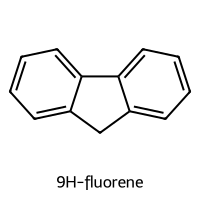

=== 9H-fluorene ===
SMILES: c1ccc2c(c1)Cc1ccccc1-2
Descriptors [MolWt, LogP, TPSA, NumRings]: [166.22   3.26   0.     3.  ]
10-Descriptor Vector: [1.6622e+02 3.2600e+00 0.0000e+00 3.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 1.3000e+01 8.0000e-02 2.0000e+00]
Fingerprint: 11000000000000100100101010001010



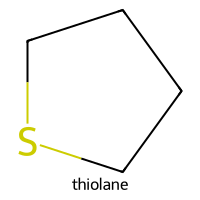

=== thiolane ===
SMILES: C1CCSC1
Descriptors [MolWt, LogP, TPSA, NumRings]: [88.18  1.51  0.    1.  ]
10-Descriptor Vector: [88.18  1.51  0.    1.    1.    0.    0.    5.    1.    0.  ]
Fingerprint: 00001100000000010000010000000010



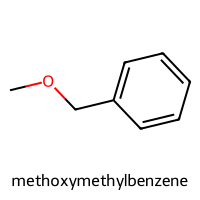

=== methoxymethylbenzene ===
SMILES: COCc1ccccc1
Descriptors [MolWt, LogP, TPSA, NumRings]: [122.17   1.83   9.23   1.  ]
10-Descriptor Vector: [122.17   1.83   9.23   1.     1.     0.     2.     9.     0.25   1.  ]
Fingerprint: 10000100010000001100001000100000



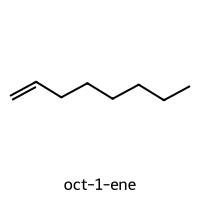

=== oct-1-ene ===
SMILES: C=CCCCCCC
Descriptors [MolWt, LogP, TPSA, NumRings]: [112.22   3.14   0.     0.  ]
10-Descriptor Vector: [112.22   3.14   0.     0.     0.     0.     5.     8.     0.75   0.  ]
Fingerprint: 00000000000000011100001000100001



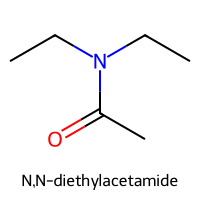

=== N,N-diethylacetamide ===
SMILES: CCN(CC)C(C)=O
Descriptors [MolWt, LogP, TPSA, NumRings]: [115.18   0.87  20.31   0.  ]
10-Descriptor Vector: [115.18   0.87  20.31   0.     1.     0.     2.     8.     0.83   0.  ]
Fingerprint: 00000000001000001010000000000100



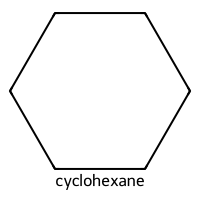

=== cyclohexane ===
SMILES: C1CCCCC1
Descriptors [MolWt, LogP, TPSA, NumRings]: [84.16  2.34  0.    1.  ]
10-Descriptor Vector: [84.16  2.34  0.    1.    0.    0.    0.    6.    1.    0.  ]
Fingerprint: 00101000000000000000000000000010



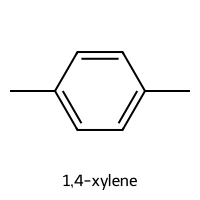

=== 1,4-xylene ===
SMILES: Cc1ccc(C)cc1
Descriptors [MolWt, LogP, TPSA, NumRings]: [106.17   2.3    0.     1.  ]
10-Descriptor Vector: [106.17   2.3    0.     1.     0.     0.     0.     8.     0.25   1.  ]
Fingerprint: 10000000000000000100001000000001



In [6]:

import random
from rdkit.Chem import Draw

# pick indices you want
sample_indices = [1, 5, 7, 15, 20, 80, 100]

# make sure you have all descriptor sets ready
desc4 = df_raw["SMILES"].apply(calc_descriptors)
desc10 = df_raw["SMILES"].apply(calc_descriptors10)
df_all = pd.concat([df_raw, desc4, desc10.add_prefix("d10_"), df_morgan["Fingerprint"]], axis=1)

# loop through chosen indices
for idx in sample_indices:
    row = df_all.iloc[idx]
    mol = Chem.MolFromSmiles(row["SMILES"])
    img = Draw.MolToImage(mol, size=(200, 200), legend=row["Compound Name"])
    display(img)

    print(f"=== {row['Compound Name']} ===")
    print("SMILES:", row["SMILES"])

    # 4-descriptor set
    d4 = np.round([row["MolWt"], row["LogP"], row["TPSA"], row["NumRings"]], 2)
    print("Descriptors [MolWt, LogP, TPSA, NumRings]:", d4)

    # 10-descriptor set
    d10_keys = ["MolWt","LogP","TPSA","NumRings","NumHAcceptors","NumHDonors",
                "NumRotatableBonds","HeavyAtomCount","FractionCSP3","NumAromaticRings"]
    d10 = np.round([row["d10_"+k] for k in d10_keys], 2)
    print("10-Descriptor Vector:", d10)
    print("Fingerprint:", row["Fingerprint"][:32])

    print()


- The 4-descriptor table is easy to standardize and to interpret.
- The 1024-bit fingerprint captures substructure presence or absence and is useful for neighborhood maps.

With 4-desciptor, it's easier to visualize:

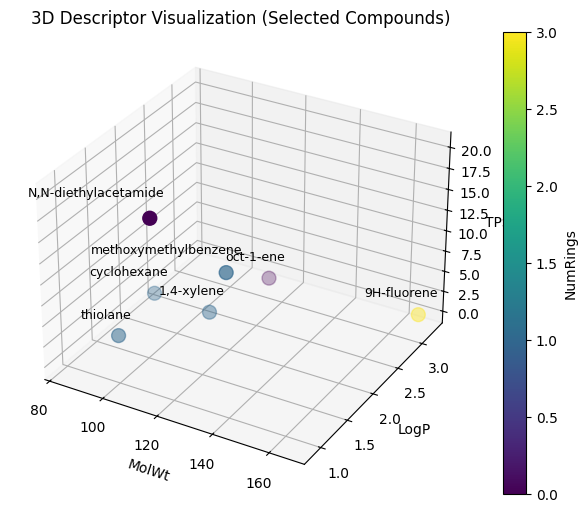

In [7]:
from mpl_toolkits.mplot3d import Axes3D

# pick specific indices
df_sel = df_all.iloc[sample_indices]   # df_all includes your descriptors

# --- 3D scatter plot ---
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    df_sel["MolWt"], df_sel["LogP"], df_sel["TPSA"],
    c=df_sel["NumRings"], cmap="viridis", s=100
)

# add labels to points
for i, row in df_sel.iterrows():
    ax.text(
        row["MolWt"]+10 ,   # shift value so no overlap
        row["LogP"]-0.21,
        row["TPSA"]+4.5,
        row["Compound Name"],
        ha="right",   # align text to the right
        fontsize=9
    )

ax.set_xlabel("MolWt")
ax.set_ylabel("LogP")
ax.set_zlabel("TPSA")
plt.colorbar(sc, label="NumRings")
plt.title("3D Descriptor Visualization (Selected Compounds)")
plt.show()

Now we can apply this to the entire C-H oxidation dataset.

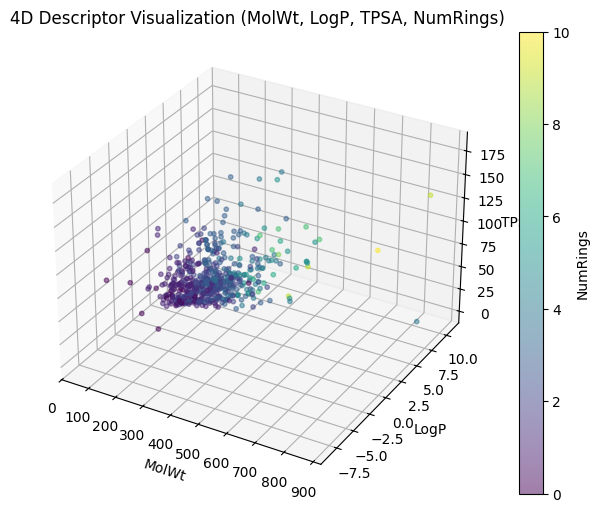

In [8]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    df4["MolWt"],
    df4["LogP"],
    df4["TPSA"],
    c=df4["NumRings"], cmap="viridis", s=10, alpha=0.5
)

ax.set_xlabel("MolWt")
ax.set_ylabel("LogP")
ax.set_zlabel("TPSA")

plt.colorbar(sc, label="NumRings")  # 4th dimension
plt.title("4D Descriptor Visualization (MolWt, LogP, TPSA, NumRings)")
plt.show()

And depending which three descriptors you used for XYZ, you can have different plottings.

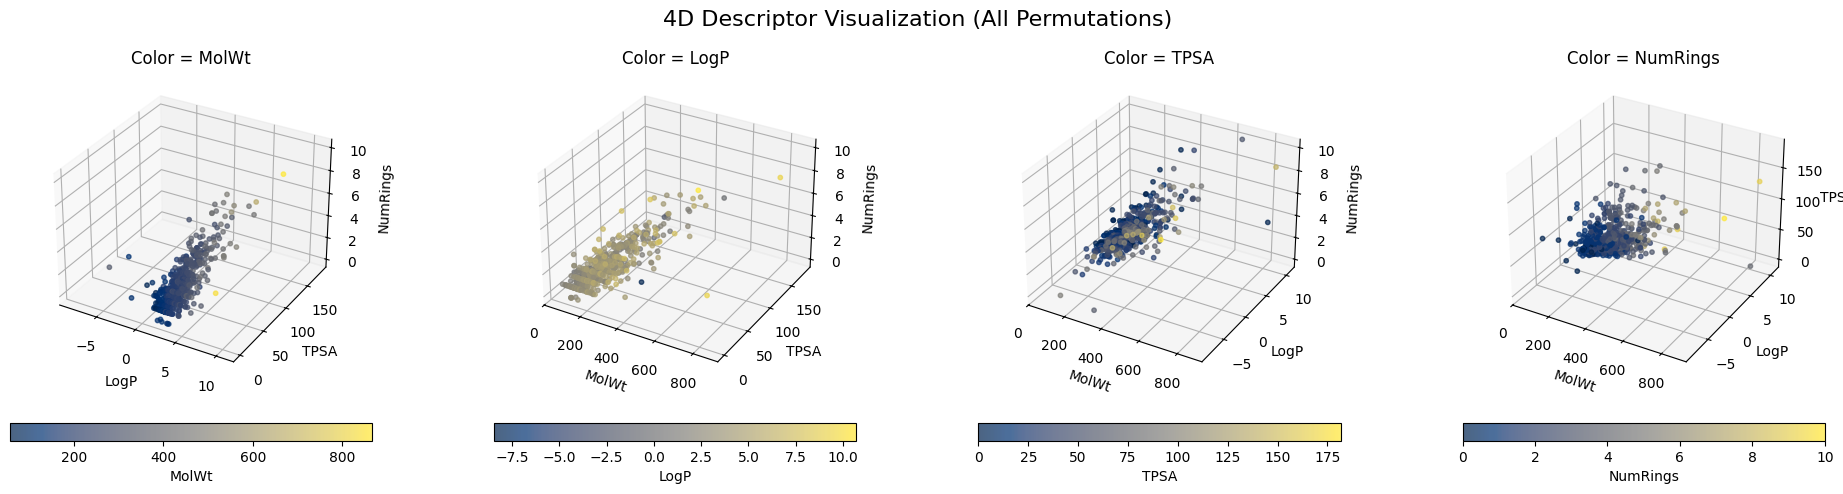

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# All 4 descriptors
descs = ["MolWt", "LogP", "TPSA", "NumRings"]

fig = plt.figure(figsize=(20,5))

for i, color_dim in enumerate(descs, 1):
    # the other three go on axes
    axes_dims = [d for d in descs if d != color_dim]
    xcol, ycol, zcol = axes_dims

    ax = fig.add_subplot(1, 4, i, projection="3d")

    sc = ax.scatter(
        df4[xcol], df4[ycol], df4[zcol],
        c=df4[color_dim], cmap="cividis", s=10, alpha=0.7
    )

    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    ax.set_zlabel(zcol)
    ax.set_title(f"Color = {color_dim}")

    # horizontal colorbar under each subplot
    cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.1, shrink=0.7)
    cbar.set_label(color_dim)

plt.suptitle("4D Descriptor Visualization (All Permutations)", fontsize=16)
plt.tight_layout()
plt.show()

But when it comes to 10-dimensional descriptors or even something like a 1024-dimensional Morgan fingerprint, it is nearly impossible to directly visualize them. It becomes even harder to know the "neigbors" to a specific molecule.

Humans can only intuitively grasp two or three axes at once. Once you go beyond that, you can only look at pairs of dimensions at a time, and the relationships quickly become hard to characterize.

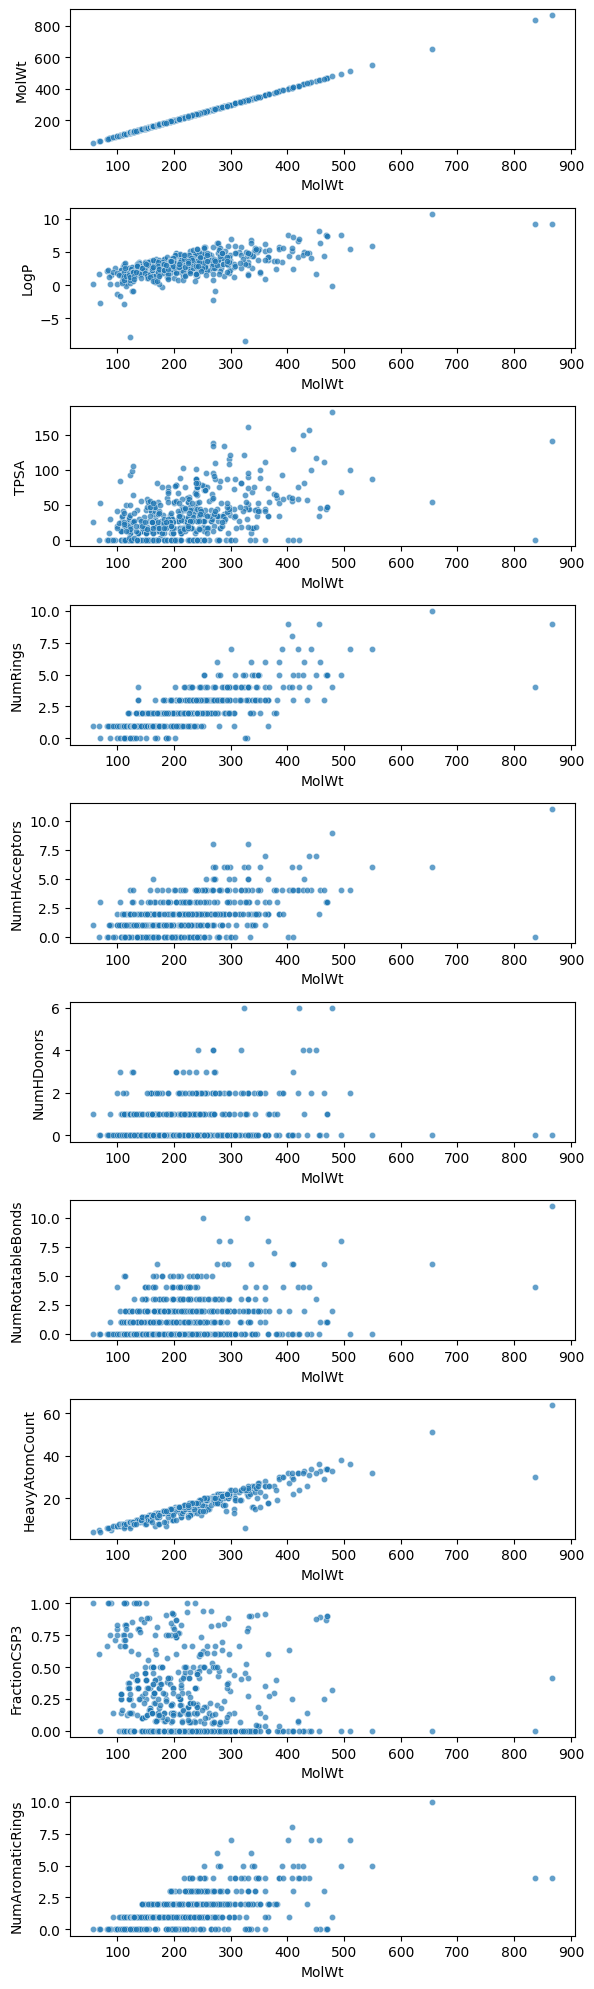

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

vars = ["MolWt","LogP","TPSA","NumRings",
        "NumHAcceptors","NumHDonors","NumRotatableBonds",
        "HeavyAtomCount","FractionCSP3","NumAromaticRings"]

fig, axes = plt.subplots(len(vars), 1, figsize=(6, 20), sharex=False)

for i, v in enumerate(vars):
    sns.scatterplot(
        data=df10,
        x="MolWt", y=v,   # fix one descriptor on x-axis (e.g., MolWt)
        ax=axes[i], s=20, alpha=0.7
    )
    axes[i].set_ylabel(v)

plt.tight_layout()
plt.show()

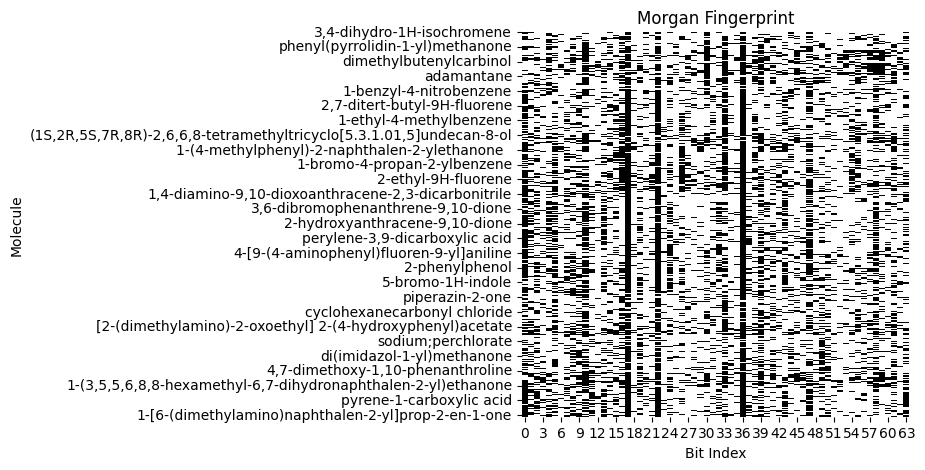

In [11]:
# expand "0101..." strings into arrays of integers
fp_matrix = df_morgan["Fingerprint"].apply(lambda x: [int(ch) for ch in x]).tolist()
fp_df = pd.DataFrame(fp_matrix, index=df_morgan["Compound Name"])

plt.figure(figsize=(5,5))
sns.heatmap(fp_df, cmap="Greys", cbar=False)
plt.title("Morgan Fingerprint")
plt.xlabel("Bit Index")
plt.ylabel("Molecule")
plt.show()

That’s why cheminformatics usually applies **dimension reduction** methods (PCA, t-SNE, UMAP) to compress high-dimensional data into a visualizable 2D or 3D form. We will get to these points today!


---

## 2. Supervised vs unsupervised

In Lectures 6 to 8 we learned supervised models that map $x \to y$ with labeled targets. Today we switch to **unsupervised learning**.

- **Dimension reduction**: summarize high dimensional $x \in \mathbb{R}^p$ to a few coordinates $z \in \mathbb{R}^k$ with $k \ll p$. You do not use $y$ during the fit.
- **Clustering**: group samples into clusters based on a similarity or distance rule. Again no labels during the fit.

We will color plots using toxicity when available. That is only to **interpret** the embedding or clusters. It is not used in the algorithms.

```{admonition} ⏰ Exercise 2

State whether each task is supervised or unsupervised:

- Predict melting point from descriptors.
- Group molecules by scaffold similarity.
- Map 1024-bit fingerprints to 2D for plotting.
- Predict toxicity from descriptors.
```
### 2.1 Principal Component Analysis (PCA)

Feature choices will drive everything downstream. You can use:

- Scalar descriptors like MolWt, LogP, TPSA, ring counts.
- Fingerprints like Morgan bits or MACCS keys.
- Learned embeddings from a graph neural network. We will not use those here, but the same methods apply.

If two students use different features, their dimension reduction plots will look different. That is expected.

> So, how do we start with dimension reduction?
Let's first try **Principal Component Analysis (PCA)**
In the previous section, when we move from **4 descriptors** (MolWt, LogP, TPSA, NumRings) to **10 descriptors** or even **64-bit Morgan fingerprints**, direct visualization becomes impossible. You can only plot a few dimensions at a time, and the relationships across all features become hard to interpret.

PCA addresses this challenge by finding **new axes (principal components)** that summarize the directions of greatest variance in the data. These axes are:

- **Orthogonal** (uncorrelated).
- **Ranked by importance** (PC1 explains the most variance, PC2 the second most, and so on).
- **Linear combinations** of the original features.

Thus, PCA compresses high-dimensional molecular representations into just **2 or 3 coordinates** that can be plotted.



Below is the mathematical pieces:

1. Start with standardized data $\tilde X$ (mean 0, variance 1 across features).
2. Compute the covariance matrix:
   $
   S = \frac{1}{n-1}\tilde X^\top \tilde X
   $
3. Either:
   - Eigen-decompose $S$ → eigenvectors are principal directions.
   - Or compute SVD:
     $
     \tilde X = U \Sigma V^\top
     $
4. The top $k$ eigenvectors (or columns of $V$) form the principal directions.
5. The new coordinates are:
   $
   Z = \tilde X V_k
   $
   where $Z$ are the principal component scores.

---
What this means for our chemistry dataset (`df10`)

- `df10` contains **10 molecular descriptors** for each compound:
  - MolWt, LogP, TPSA, NumRings,
  - NumHAcceptors, NumHDonors,
  - NumRotatableBonds, HeavyAtomCount,
  - FractionCSP3, NumAromaticRings.

- These form a data matrix $X$ of shape **(n molecules × 10 features)**.

- PCA standardizes each column (feature) so they are comparable on the same scale.  
  For example, MolWt ranges in the hundreds, but FractionCSP3 is between 0 and 1. Standardization makes both contribute fairly.

- Then PCA computes **principal directions** as linear combinations of these 10 descriptors.  

- The result is a new score matrix $Z$ of shape **(n molecules × k components)**, usually with $k=2$ or $3$ for visualization.  
  This means each molecule is now represented by just 2–3 numbers (PC1, PC2, PC3) instead of 10 descriptors.

- The same approach works for fingerprints: instead of 10 columns, you may have 64, 1024, or 2048. PCA reduces that down to 2–3 interpretable axes.

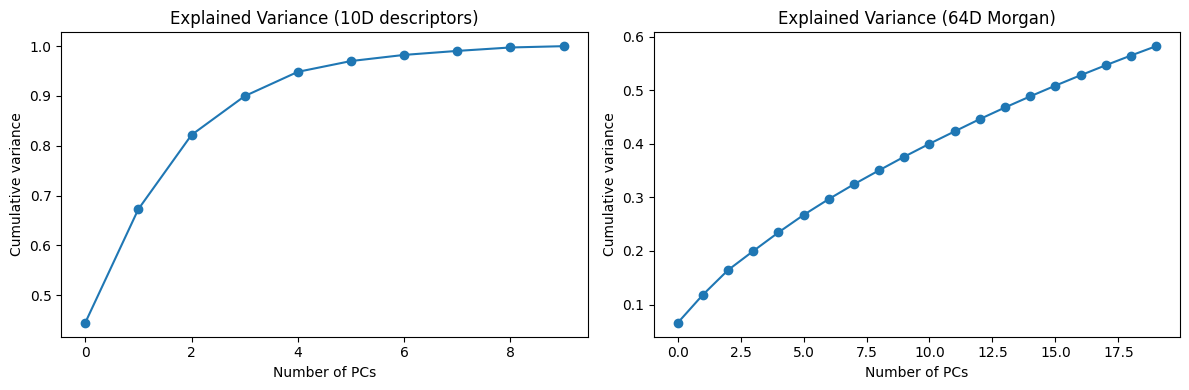

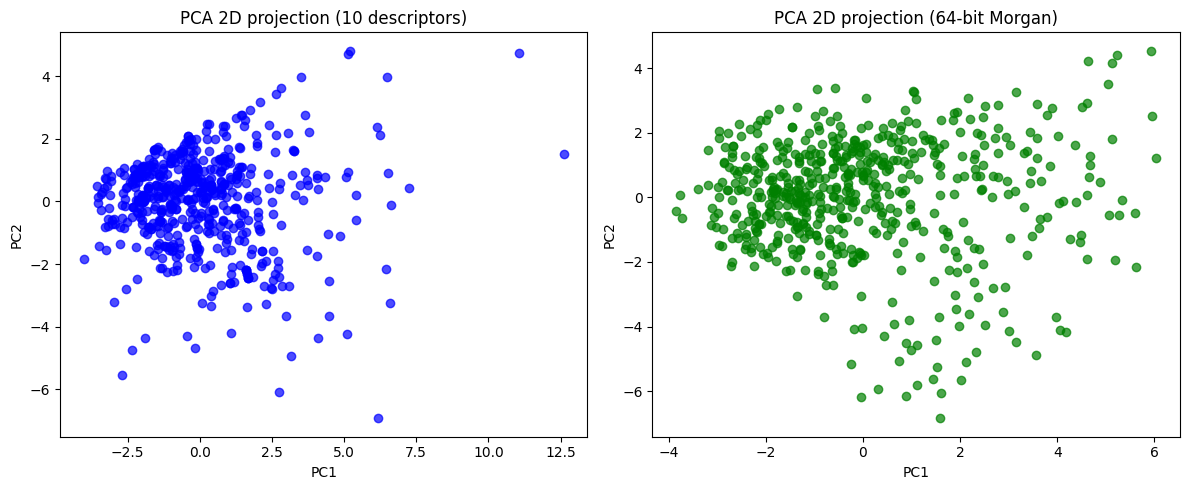

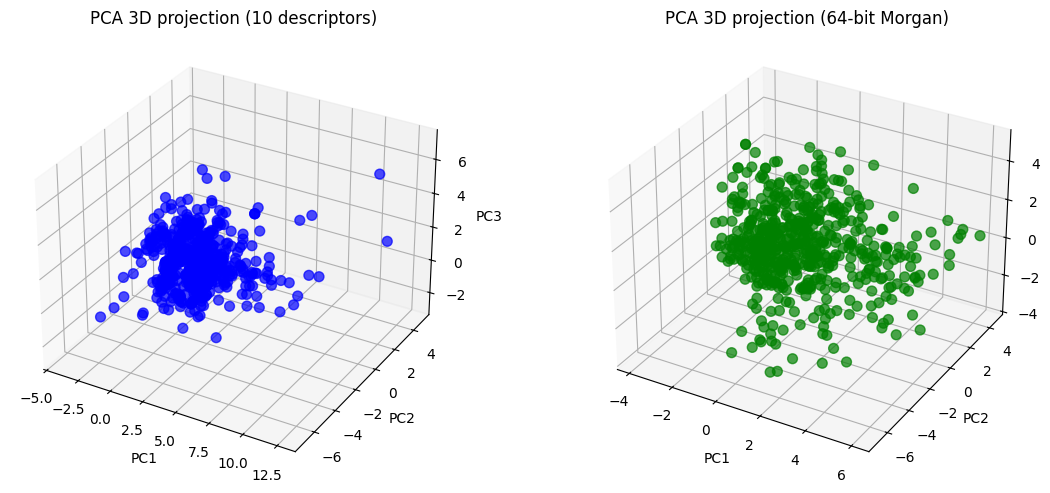

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# ---- prepare matrices ----
X_desc = df10[["MolWt","LogP","TPSA","NumRings",
               "NumHAcceptors","NumHDonors","NumRotatableBonds",
               "HeavyAtomCount","FractionCSP3","NumAromaticRings"]].values

X_morgan = np.array([[int(ch) for ch in fp] for fp in df_morgan["Fingerprint"]])  # 64 bits

# ---- standardize ----
X_desc_std = StandardScaler().fit_transform(X_desc)
X_morgan_std = StandardScaler().fit_transform(X_morgan)

# ---- PCA fit ----
pca_desc = PCA().fit(X_desc_std)
pca_morgan = PCA().fit(X_morgan_std)

# ---- scree plots ----
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].plot(np.cumsum(pca_desc.explained_variance_ratio_[:10]), marker="o")
axes[0].set_title("Explained Variance (10D descriptors)")
axes[0].set_xlabel("Number of PCs")
axes[0].set_ylabel("Cumulative variance")

axes[1].plot(np.cumsum(pca_morgan.explained_variance_ratio_[:20]), marker="o")
axes[1].set_title("Explained Variance (64D Morgan)")
axes[1].set_xlabel("Number of PCs")
axes[1].set_ylabel("Cumulative variance")

plt.tight_layout()
plt.show()

# ---- 2D PCA projections ----
desc_2d = pca_desc.transform(X_desc_std)[:, :2]
morgan_2d = pca_morgan.transform(X_morgan_std)[:, :2]

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].scatter(desc_2d[:,0], desc_2d[:,1], c="blue", alpha=0.7)
axes[0].set_title("PCA 2D projection (10 descriptors)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

axes[1].scatter(morgan_2d[:,0], morgan_2d[:,1], c="green", alpha=0.7)
axes[1].set_title("PCA 2D projection (64-bit Morgan)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()

# ---- 3D PCA projections ----
desc_3d = pca_desc.transform(X_desc_std)[:, :3]
morgan_3d = pca_morgan.transform(X_morgan_std)[:, :3]

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121, projection="3d")
ax1.scatter(desc_3d[:,0], desc_3d[:,1], desc_3d[:,2],
            c="blue", alpha=0.7, s=50)
ax1.set_title("PCA 3D projection (10 descriptors)")
ax1.set_xlabel("PC1"); ax1.set_ylabel("PC2"); ax1.set_zlabel("PC3")

ax2 = fig.add_subplot(122, projection="3d")
ax2.scatter(morgan_3d[:,0], morgan_3d[:,1], morgan_3d[:,2],
            c="green", alpha=0.7, s=50)
ax2.set_title("PCA 3D projection (64-bit Morgan)")
ax2.set_xlabel("PC1"); ax2.set_ylabel("PC2"); ax2.set_zlabel("PC3")

plt.tight_layout()
plt.show()

Now you can see, the 10D vector is converted to 2D or 3D vector, which become much easier to plot.

In [13]:
desc_2d

array([[-1.85863457,  0.10406515],
       [-0.8662983 ,  1.26269482],
       [-2.08798314,  0.77811   ],
       ...,
       [ 0.08373577,  0.58690452],
       [ 3.19411974,  0.85437761],
       [ 2.00081897,  0.04085639]], shape=(575, 2))

In [14]:
desc_3d

array([[-1.85863457,  0.10406515, -0.76130014],
       [-0.8662983 ,  1.26269482, -1.55622595],
       [-2.08798314,  0.77811   , -0.75279025],
       ...,
       [ 0.08373577,  0.58690452,  0.27978755],
       [ 3.19411974,  0.85437761,  0.07107396],
       [ 2.00081897,  0.04085639,  0.17583671]], shape=(575, 3))

In essence, PCA gives us coordinates for each molecule in a reduced 2D space.  
To make this more concrete, we can select specific molecules and compare them:

- A **manual pair** that we choose (indices 0 and 5).  
- The **closest pair** in PCA space (most similar according to the descriptors).  
- The **farthest pair** in PCA space (most dissimilar).  

We plot all molecules in grey, highlight the pairs with different colors, and draw a line connecting each pair.  
For the selected molecules we also show their **structure, compound name, and PCA coordinates**.

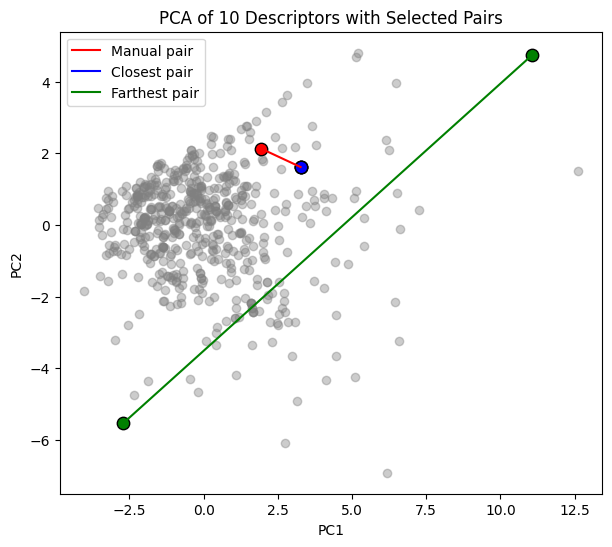

=== Manual pair ===


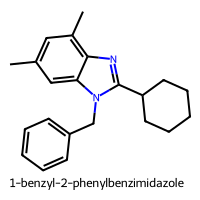

1-benzyl-2-phenylbenzimidazole   (index 225)
  PC1 = 1.936, PC2 = 2.132


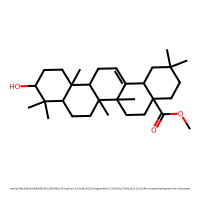

methyl (4aS,6aR,6aS,6bR,8aR,10S,12aR,14bS)-10-hydroxy-2,2,6a,6b,9,9,12a-heptamethyl-1,3,4,5,6,6a,7,8,8a,10,11,12,13,14b-tetradecahydropicene-4a-carboxylate (index 35)
  PC1 = 3.267, PC2 = 1.618

=== Closest pair ===


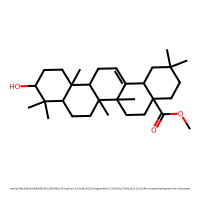

methyl (4aS,6aR,6aS,6bR,8aR,10S,12aR,14bS)-10-hydroxy-2,2,6a,6b,9,9,12a-heptamethyl-1,3,4,5,6,6a,7,8,8a,10,11,12,13,14b-tetradecahydropicene-4a-carboxylate (index 35)
  PC1 = 3.267, PC2 = 1.618


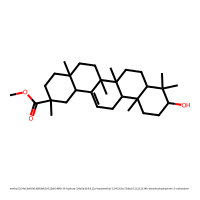

methyl (2S,4aS,6aR,6aS,6bR,8aR,10S,12aR,14bR)-10-hydroxy-2,4a,6a,6b,9,9,12a-heptamethyl-1,3,4,5,6,6a,7,8,8a,10,11,12,13,14b-tetradecahydropicene-2-carboxylate   (index 64)
  PC1 = 3.267, PC2 = 1.618

=== Farthest pair ===


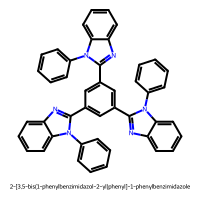

2-[3,5-bis(1-phenylbenzimidazol-2-yl)phenyl]-1-phenylbenzimidazole (index 338)
  PC1 = 11.072, PC2 = 4.750


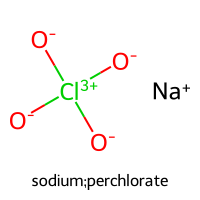

sodium;perchlorate (index 462)
  PC1 = -2.699, PC2 = -5.531



In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import combinations

# ---- prepare feature matrix ----
X_desc = df10[["MolWt","LogP","TPSA","NumRings",
               "NumHAcceptors","NumHDonors","NumRotatableBonds",
               "HeavyAtomCount","FractionCSP3","NumAromaticRings"]].values

# ---- standardize and PCA ----
X_desc_std = StandardScaler().fit_transform(X_desc)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_desc_std)

# ---- distance matrix to find closest/farthest ----
pairs = list(combinations(range(len(X_pca)), 2))
distances = [np.linalg.norm(X_pca[i]-X_pca[j]) for i,j in pairs]
farthest = pairs[np.argmax(distances)]
closest = pairs[np.argmin(distances)]

# ---- chosen pairs ----
manual_pair = (225,35)
pairs_to_show = [("Manual pair", manual_pair),
                 ("Closest pair", closest),
                 ("Farthest pair", farthest)]

# ---- scatter plot ----
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c="grey", alpha=0.4)

colors = ["red","blue","green"]
for (label,(i,j)),c in zip(pairs_to_show, colors):
    plt.scatter(X_pca[i,0], X_pca[i,1], c=c, s=80, edgecolor="black")
    plt.scatter(X_pca[j,0], X_pca[j,1], c=c, s=80, edgecolor="black")
    plt.plot([X_pca[i,0],X_pca[j,0]],[X_pca[i,1],X_pca[j,1]],c=c,label=label)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("PCA of 10 Descriptors with Selected Pairs")
plt.show()

# ---- show structures + coordinates ----
for label, (i,j) in pairs_to_show:
    print(f"=== {label} ===")
    for idx in (i,j):
        name = df10.iloc[idx]["Compound Name"]
        smiles = df10.iloc[idx]["SMILES"]
        mol = Chem.MolFromSmiles(smiles)
        img = Draw.MolToImage(mol, size=(200,200), legend=name)
        display(img)
        print(f"{name} (index {idx})")
        print(f"  PC1 = {X_pca[idx,0]:.3f}, PC2 = {X_pca[idx,1]:.3f}")
    print()

We can also make this plot to be interactive:

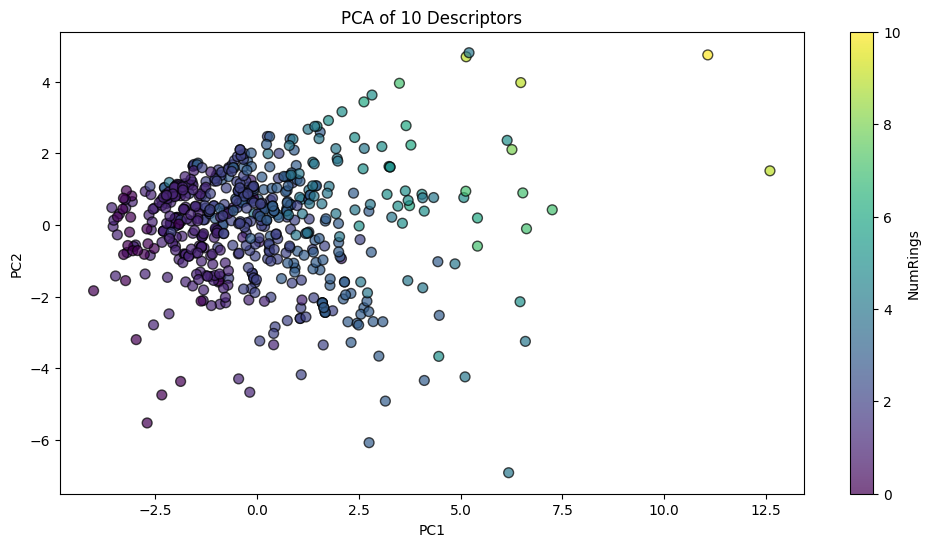

In [16]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ---- prepare feature matrix ----
desc_cols = ["MolWt","LogP","TPSA","NumRings",
             "NumHAcceptors","NumHDonors","NumRotatableBonds",
             "HeavyAtomCount","FractionCSP3","NumAromaticRings"]

X_desc = df10[desc_cols].values

# ---- standardize and PCA ----
X_desc_std = StandardScaler().fit_transform(X_desc)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_desc_std)

# ---- build dataframe with PCA scores ----
df_pca = df10.copy()
df_pca["PC1"] = X_pca[:,0]
df_pca["PC2"] = X_pca[:,1]

# ---- scatter plot with matplotlib ----
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    df_pca["PC1"],
    df_pca["PC2"],
    c=df_pca["NumRings"],  # color by number of rings
    cmap="viridis",
    s=50,                  # marker size
    alpha=0.7,
    edgecolor="k"
)

# add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label("NumRings")

# titles and labels
plt.title("PCA of 10 Descriptors")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()


### 2.2 Data leakage in unsupervised settings

Even in unsupervised workflows, leakage can happen.  
A common mistake is to **fit the scaler or PCA on the full dataset** before splitting.  
This means the test set has already influenced the scaling or component directions, which is a subtle form of information leak.  

**Safer pattern**:  
1. Split the dataset into train and test.  
2. Fit the scaler only on the training subset.  
3. Transform both train and test using the fitted scaler.  
4. Fit PCA (or clustering) on the training data only, then apply the transform to the test set.  

This way the test set truly remains unseen during model fitting.

Train shape: (402, 2)
Test shape: (173, 2)


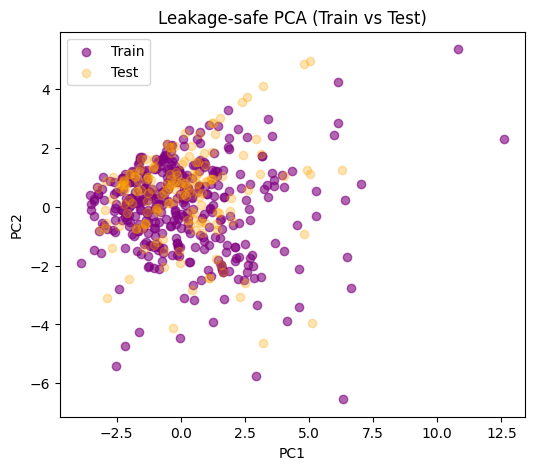

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ---- features ----
desc_cols = ["MolWt","LogP","TPSA","NumRings",
             "NumHAcceptors","NumHDonors","NumRotatableBonds",
             "HeavyAtomCount","FractionCSP3","NumAromaticRings"]

X = df10[desc_cols].values

# ---- split first ----
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# ---- fit scaler on train only ----
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

# ---- fit PCA on train only ----
pca = PCA(n_components=2).fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print("Train shape:", X_train_pca.shape)
print("Test shape:", X_test_pca.shape)

# ---- visualize ----
plt.figure(figsize=(6,5))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c="purple", label="Train", alpha=0.6)
plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c="orange", label="Test", alpha=0.3, marker="o")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Leakage-safe PCA (Train vs Test)")
plt.legend()
plt.show()

If the test set overlaps reasonably with the distribution of the train set, that’s a sign your train-derived scaling and PCA directions generalize.

If the test points lie far outside, that could mean:

- Train and test distributions are very different.
- Or PCA didn’t capture the structure of test molecules well.
Note:

- In pure visualization use cases, the risk is smaller since we are not optimizing a predictive model.
- For cluster analysis that will be compared to labels afterward, keep the split discipline.

---

## 3. Standardization and distance

Unsupervised methods depend on a distance or similarity rule. The choice of distance and the way you scale features can completely change neighborhoods, clusters, and embeddings. This section covers why we standardize, which distance to use for scalar descriptors vs fingerprints, and how to compute and visualize distance in a leakage safe way.


### 3.1 Why standardize

Descriptor columns live on different scales. `MolWt` can be in the hundreds. `FractionCSP3` is in `[0, 1]`. If you compute Euclidean distance on the raw matrix, large scale columns dominate. Standardization fixes this by centering and scaling each column so that all features contribute fairly.

Common scalers:
- **StandardScaler**: zero mean, unit variance. Good default.
- **MinMaxScaler**: rescales to [0, 1]. Useful when you want bounded ranges.
- **RobustScaler**: uses medians and IQR. Useful with outliers.



Below is an example for `StandardScaler()`

Raw means: [223.213  32.74 ]
Raw stds : [92.66  30.417]
Std means: [ 0. -0.]
Std stds : [1. 1.]


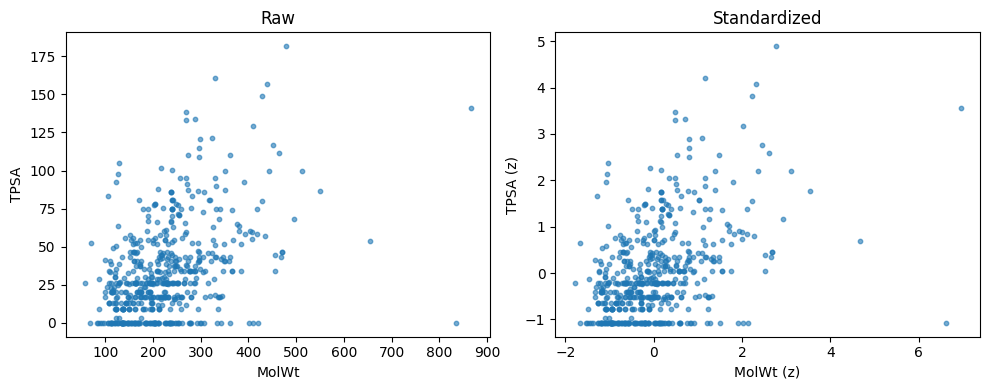

In [18]:
from sklearn.preprocessing import StandardScaler

# pick two columns
cols2 = ["MolWt", "TPSA"]
X2 = df10[cols2].to_numpy()

# standardize both columns
scaler = StandardScaler().fit(X2)
X2_std = scaler.transform(X2)

# show means and std before vs after
print("Raw means:", np.round(X2.mean(axis=0), 3))
print("Raw stds :", np.round(X2.std(axis=0, ddof=0), 3))
print("Std means:", np.round(X2_std.mean(axis=0), 3))
print("Std stds :", np.round(X2_std.std(axis=0, ddof=0), 3))

# quick scatter before vs after
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(X2[:,0], X2[:,1], s=10, alpha=0.6)
ax[0].set_xlabel("MolWt"); ax[0].set_ylabel("TPSA"); ax[0].set_title("Raw")

ax[1].scatter(X2_std[:,0], X2_std[:,1], s=10, alpha=0.6)
ax[1].set_xlabel("MolWt (z)"); ax[1].set_ylabel("TPSA (z)"); ax[1].set_title("Standardized")
plt.tight_layout(); plt.show()

### 3.2 Which distance to use

- **Scalar descriptors** (10D):
  - **Euclidean** on standardized data is a good default.
  - **Cosine** focuses on direction rather than magnitude. Try it when overall size varies a lot.
- **Fingerprints** (64D or 1024D binary bits):
  - **Tanimoto similarity** is the chem-informatics standard. Tanimoto distance = 1 − Tanimoto similarity.
  - You can also compute cosine, but Tanimoto aligns with bitset overlap and is more common for substructure style features.


Below are equations:

- **Euclidean distance** between rows $x_i, x_j \in \mathbb{R}^d$  
  $
  d_{\text{Euc}}(i,j)=\left\|x_i-x_j\right\|_2=\sqrt{\sum_{k=1}^{d}\left(x_{ik}-x_{jk}\right)^2}
  $
- **Cosine distance** (1 minus cosine similarity)  
  $
  d_{\text{Cos}}(i,j)=1-\frac{x_i^\top x_j}{\lVert x_i\rVert_2\,\lVert x_j\rVert_2}
  $
- **Tanimoto distance** for bit vectors $b_i,b_j\in\{0,1\}^m$ with on-bit sets $A,B$  
  $
  s_{\text{Tan}}(i,j)=\frac{|A\cap B|}{|A|+|B|-|A\cap B|},\qquad
  d_{\text{Tan}}(i,j)=1-s_{\text{Tan}}(i,j)
  $


Below we show Euclidean vs Cosine on two standardized columns

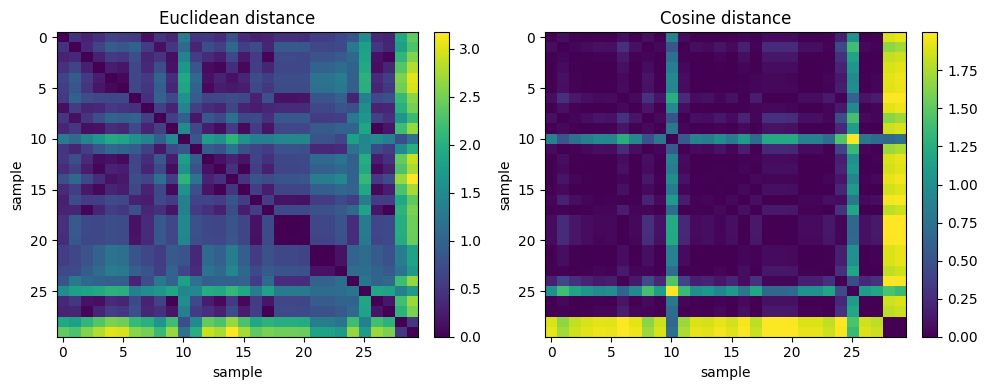

Euclidean Nearest Neighbor (rows) for sample #10: [23, 28, 21, 22, 11]
Cosine Nearest Neighbor (rows) for sample #10: [8, 1, 11, 28, 27]


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

# two columns for a small, clear demo
cols2 = ["MolWt", "TPSA"]
X2 = df10[cols2].to_numpy()

# standardize
X2_std = StandardScaler().fit_transform(X2)

# take a tiny subset to keep visuals readable
Xsmall = X2_std[:30]

# pairwise distances
D_eu = pairwise_distances(Xsmall, metric="euclidean")
D_co = pairwise_distances(Xsmall, metric="cosine")

# heatmaps side by side
fig, ax = plt.subplots(1, 2, figsize=(10,4))
im0 = ax[0].imshow(D_eu, aspect="auto")
ax[0].set_title("Euclidean distance")
ax[0].set_xlabel("sample"); ax[0].set_ylabel("sample")
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(D_co, aspect="auto")
ax[1].set_title("Cosine distance")
ax[1].set_xlabel("sample"); ax[1].set_ylabel("sample")
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout(); plt.show()

# highlight how neighbors can change across metrics
q = 10
eu_nn = np.argsort(D_eu[q])[1:6]
co_nn = np.argsort(D_co[q])[1:6]
print("Euclidean Nearest Neighbor (rows) for sample #10:", eu_nn.tolist())
print("Cosine Nearest Neighbor (rows) for sample #10:", co_nn.tolist())

```{admonition} Note
Idea is that, the same query point can have different nearest neighbors under Euclidean vs Cosine because one metric cares about absolute offsets while the other cares about direction.
```

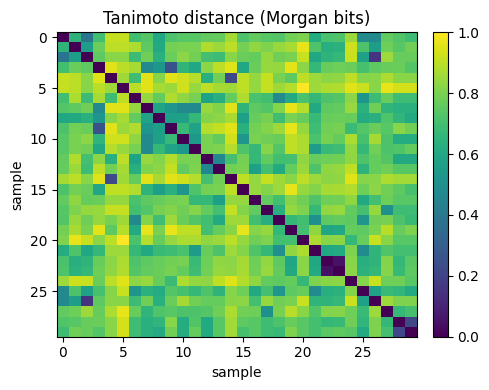

Tanimoto NN (rows) for query 10: [7, 15, 11, 8, 28]


In [20]:
# take first 30 molecules to keep plot compact
fp_strings = df_morgan["Fingerprint"].iloc[:30].tolist()

def fp_string_to_bitvect(fp_str):
    arr = [int(ch) for ch in fp_str]
    bv = DataStructs.ExplicitBitVect(len(arr))
    for k, b in enumerate(arr):
        if b: bv.SetBit(k)
    return bv

fps = [fp_string_to_bitvect(s) for s in fp_strings]

# similarities and distances
n = len(fps)
S = np.zeros((n, n))
for i in range(n):
    S[i, :] = DataStructs.BulkTanimotoSimilarity(fps[i], fps)

D_tan = 1.0 - S

# heatmap
plt.figure(figsize=(5,4))
im = plt.imshow(D_tan, aspect="auto")
plt.title("Tanimoto distance (Morgan bits)")
plt.xlabel("sample"); plt.ylabel("sample")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

# nearest neighbors under Tanimoto
q = 10
nn_tan = np.argsort(D_tan[q])[1:6]
print("Tanimoto NN (rows) for query 10:", nn_tan.tolist())

```{admonition} Note
Idea is that, small Tanimoto distance means strong bit overlap, which often reflects shared substructures. This is why Tanimoto is standard for fingerprint similarity.
```
Below we add a simple 2D plot to **show how nearest neighbors can differ** under different metrics in the same fingerprint space.  
We compute a 2D embedding once (PCA on the 0/1 bit matrix) and then draw neighbor connections for all three kinds of distance calculation methods.

Tanimoto NN for query 196 -> [237, 414, 434, 11, 107]
Cosine   NN for query 196 -> [237, 414, 434, 107, 11]
Euclidean NN for query 196 -> [107, 122, 237, 414, 9]


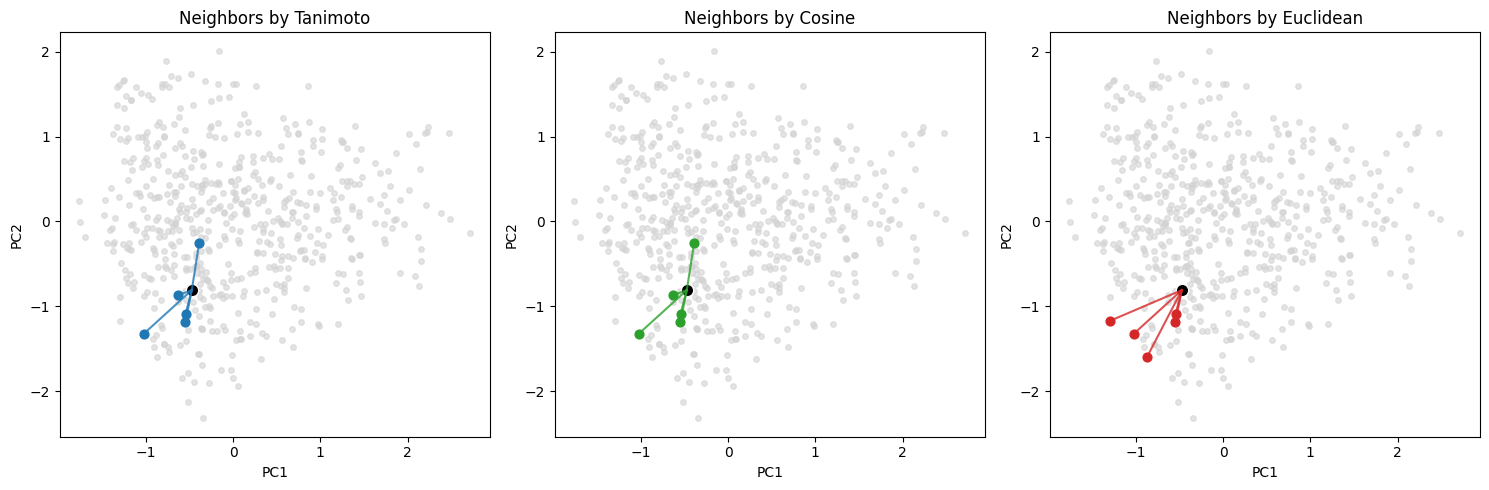

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from rdkit import DataStructs

# --- build matrices on the FULL set ---
fp_strings = df_morgan["Fingerprint"].tolist()
n = len(fp_strings)
m = len(fp_strings[0])

def fp_string_to_bitvect(fp_str):
    arr = [int(ch) for ch in fp_str]
    bv = DataStructs.ExplicitBitVect(len(arr))
    for k, b in enumerate(arr):
        if b: bv.SetBit(k)
    return bv

# RDKit bitvecs for Tanimoto
fp_bvs = [fp_string_to_bitvect(s) for s in fp_strings]

# 0/1 matrix for cosine and Euclidean
Xfp = np.array([[int(ch) for ch in s] for s in fp_strings], dtype=float)  # shape (n, m)

# --- pairwise distances in ORIGINAL space ---
# Tanimoto
S_tani = np.zeros((n, n), dtype=float)
for i in range(n):
    S_tani[i, :] = DataStructs.BulkTanimotoSimilarity(fp_bvs[i], fp_bvs)
D_tani = 1.0 - S_tani

# Cosine and Euclidean on 0/1 bits
D_cos = pairwise_distances(Xfp, metric="cosine")
D_eu  = pairwise_distances(Xfp, metric="euclidean")  # for binary, relates to Hamming

# --- 2D coordinates for plotting ONLY ---
Z = PCA(n_components=2).fit_transform(Xfp)

# --- helper for stable top-k excluding self ---
def topk_neighbors(D, q, k=5):
    order = np.argsort(D[q], kind="mergesort")  # stable
    order = order[order != q]
    return order[:k]

q = 196   # your example index
k = 5

nn_tani = topk_neighbors(D_tani, q, k)
nn_cos  = topk_neighbors(D_cos,  q, k)
nn_eu   = topk_neighbors(D_eu,   q, k)

print("Tanimoto NN for query", q, "->", nn_tani.tolist())
print("Cosine   NN for query", q, "->", nn_cos.tolist())
print("Euclidean NN for query", q, "->", nn_eu.tolist())

# --- three-panel plot: same coords, different neighbor sets ---
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for a in ax:
    a.scatter(Z[:,0], Z[:,1], c="lightgrey", s=16, alpha=0.6, label="All points")
    a.scatter(Z[q,0], Z[q,1], c="black", s=80, edgecolor="white", label="Query")
    a.set_xlabel("PC1"); a.set_ylabel("PC2")

# panel 1: Tanimoto
ax[0].scatter(Z[nn_tani,0], Z[nn_tani,1], c="tab:blue", s=40, label="kNN")
for j in nn_tani:
    ax[0].plot([Z[q,0], Z[j,0]], [Z[q,1], Z[j,1]], c="tab:blue", alpha=0.8)
ax[0].set_title("Neighbors by Tanimoto")

# panel 2: Cosine
ax[1].scatter(Z[nn_cos,0], Z[nn_cos,1], c="tab:green", s=40, label="kNN")
for j in nn_cos:
    ax[1].plot([Z[q,0], Z[j,0]], [Z[q,1], Z[j,1]], c="tab:green", alpha=0.8)
ax[1].set_title("Neighbors by Cosine")

# panel 3: Euclidean
ax[2].scatter(Z[nn_eu,0], Z[nn_eu,1], c="tab:red", s=40, label="kNN")
for j in nn_eu:
    ax[2].plot([Z[q,0], Z[j,0]], [Z[q,1], Z[j,1]], c="tab:red", alpha=0.8)
ax[2].set_title("Neighbors by Euclidean")

plt.tight_layout()
plt.show()

We can plot both the query molecule and the found neighbors to take a look:

Query #196: 3-methylbutylbenzene


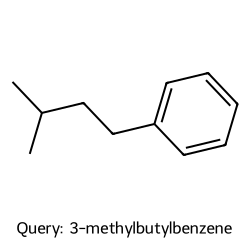

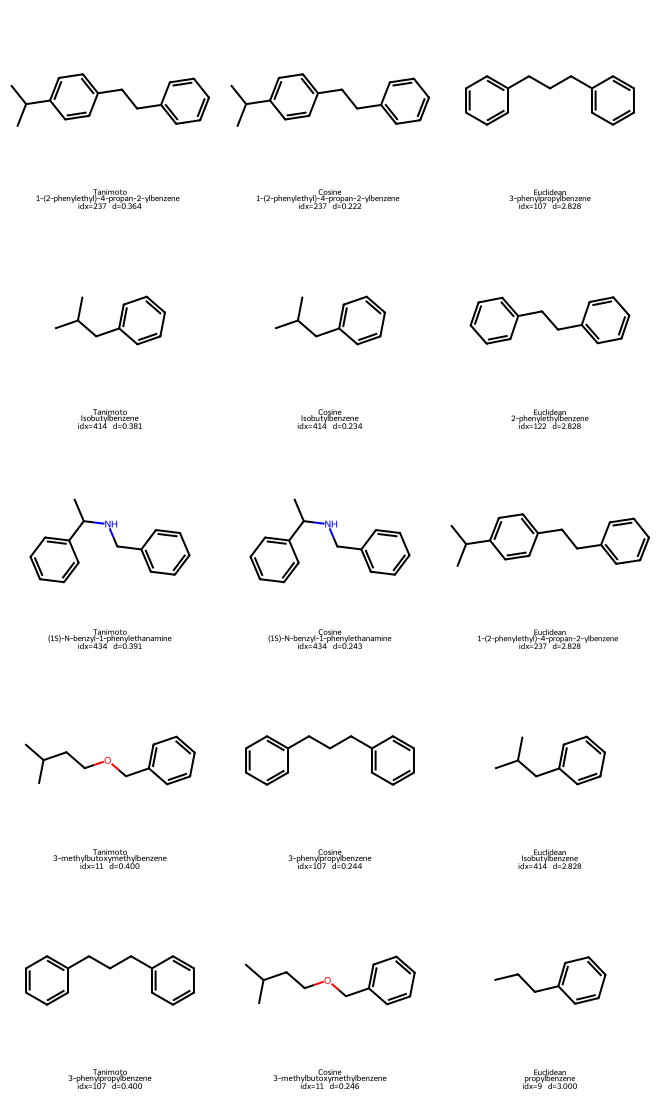

In [22]:
# 1) Draw the query molecule
q_name = df10.iloc[q]["Compound Name"]
q_smiles = df10.iloc[q]["SMILES"]
q_mol = Chem.MolFromSmiles(q_smiles)
print(f"Query #{q}: {q_name}")
display(Draw.MolToImage(q_mol, size=(250, 250), legend=f"Query: {q_name}"))

# 2) Build a 5×3 grid of neighbor structures
#    Row r: [Tanimoto_r, Cosine_r, Euclidean_r]
mols = []
legends = []

def add_neighbors(metric_name, nn_idxs, dists):
    col_mols, col_legs = [], []
    for j in nn_idxs:
        name = df10.iloc[j]["Compound Name"]
        smi  = df10.iloc[j]["SMILES"]
        mol  = Chem.MolFromSmiles(smi)
        col_mols.append(mol)
        col_legs.append(f"{metric_name}\n{name}\nidx={j}  d={dists[q, j]:.3f}")
    return col_mols, col_legs

# Prepare the three columns (5 neighbors each)
m_tani, l_tani = add_neighbors("Tanimoto", nn_tani, D_tani)
m_cos,  l_cos  = add_neighbors("Cosine",   nn_cos,  D_cos)
m_eu,   l_eu   = add_neighbors("Euclidean",nn_eu,   D_eu)

# Interleave as rows: (Tani[r], Cos[r], Euclid[r]) for r=0..4
for r in range(5):
    mols.extend([m_tani[r], m_cos[r], m_eu[r]])
    legends.extend([l_tani[r], l_cos[r], l_eu[r]])

# Draw 5 rows × 3 columns (molsPerRow=3)
grid = Draw.MolsToGridImage(
    mols,
    molsPerRow=3,
    subImgSize=(220, 220),
    legends=legends,
)

display(grid)

## 4. Nonlinear embeddings: t-SNE and UMAP

Linear PCA gives a fast global summary. For curved manifolds or cluster-heavy data, **t-SNE** and **UMAP** often reveal structure that PCA compresses. Both start from a notion of neighborhood in the original feature space and then optimize a 2D or 3D layout that tries to keep neighbors close.

We will use two feature sets:
- **10D scalar descriptors** from `df10[desc_cols]`
- **64-bit Morgan fingerprints** from `df_morgan["Fingerprint"]`


### 4.1 t-SNE

**Idea:** Build probabilities that say which points are neighbors in high-dim, then find a low-dim map whose neighbor probabilities match.

**Math:**
- Convert distances to conditional probabilities with a Gaussian kernel per point:
  $
  p_{j\mid i}=\frac{\exp\!\left(-\frac{\lVert x_i-x_j\rVert^2}{2\sigma_i^2}\right)}{\sum_{k\ne i}\exp\!\left(-\frac{\lVert x_i-x_k\rVert^2}{2\sigma_i^2}\right)},\quad p_{i\mid i}=0
  $
  $\sigma_i$ is chosen so that the **perplexity** matches a user target (roughly the effective number of neighbors).
- Symmetrize:
  $
  P_{ij}=\frac{p_{j\mid i}+p_{i\mid j}}{2n}
  $
- In 2D, use a heavy-tailed kernel to define
  $
  q_{ij}=\frac{\left(1+\lVert y_i-y_j\rVert^2\right)^{-1}}{\sum_{k\ne \ell}\left(1+\lVert y_k-y_\ell\rVert^2\right)^{-1}},\quad q_{ii}=0
  $
- Optimize by minimizing the Kullback–Leibler divergence
  $
  \operatorname{KL}(P\parallel Q)=\sum_{i\ne j}P_{ij}\log\frac{P_{ij}}{Q_{ij}}.
  $/

**Practical tips:**
- Choose `perplexity` about 5 to 50. For ~500 molecules, start at 30.
- Standardize descriptor matrices. Fingerprints are binary. You can feed them as 0/1, or first reduce to 50 PCs for speed.

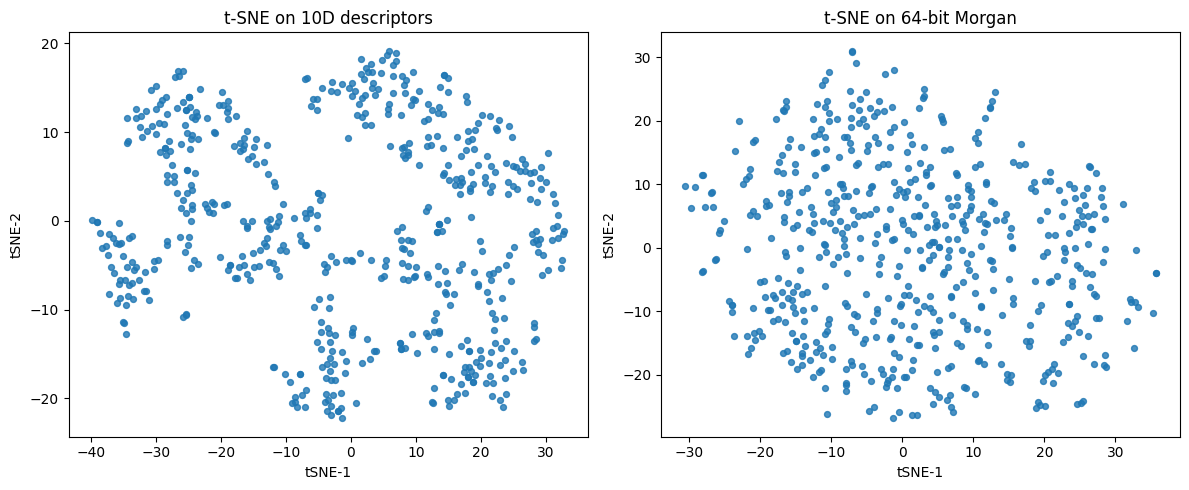

In [23]:
from sklearn.manifold import TSNE

# ----- features -----
desc_cols = ["MolWt","LogP","TPSA","NumRings",
             "NumHAcceptors","NumHDonors","NumRotatableBonds",
             "HeavyAtomCount","FractionCSP3","NumAromaticRings"]

# 10D descriptors: standardize
X_desc = df10[desc_cols].to_numpy()
X_desc_std = StandardScaler().fit_transform(X_desc)

# 64-bit Morgan: turn "0101..." into 0/1 matrix
X_fp = np.array([[int(ch) for ch in s] for s in df_morgan["Fingerprint"]], dtype=float)

# optional: speed-up via PCA(50) before t-SNE on fingerprints
#X_fp_50 = PCA(n_components=min(50, X_fp.shape[1], X_fp.shape[0]-1), random_state=0).fit_transform(X_fp)

# ----- t-SNE fits -----
tsne_desc = TSNE(n_components=2, perplexity=30, learning_rate="auto",
                 init="pca", random_state=0)
Y_desc = tsne_desc.fit_transform(X_desc_std)

tsne_fp = TSNE(n_components=2, perplexity=30, learning_rate="auto",
               init="pca", random_state=0)
Y_fp = tsne_fp.fit_transform(X_fp)

# ----- plots -----
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].scatter(Y_desc[:,0], Y_desc[:,1], s=18, alpha=0.8)
ax[0].set_title("t-SNE on 10D descriptors")
ax[0].set_xlabel("tSNE-1"); ax[0].set_ylabel("tSNE-2")

ax[1].scatter(Y_fp[:,0], Y_fp[:,1], s=18, alpha=0.8)
ax[1].set_title("t-SNE on 64-bit Morgan")
ax[1].set_xlabel("tSNE-1"); ax[1].set_ylabel("tSNE-2")

plt.tight_layout(); plt.show()

### 4.2 UMAP

**Idea:** Build a weighted kNN graph in the original space, interpret it as a fuzzy set of edges, then find low dimensional coordinates that preserve this fuzzy structure.

**Math:**

- For each point \(i\), choose a local connectivity scale so that exactly \(k\) neighbors have significant membership. Convert distances to directed fuzzy memberships $\mu_{i\to j}\in[0,1]$.

- Symmetrize with fuzzy union
  $
  \mu_{ij} = \mu_{i\to j} + \mu_{j\to i} - \mu_{i\to j}\mu_{j\to i}
  $

- In low dimension, define a differentiable edge likelihood controlled by **spread** and **min\_dist**. Optimize a cross entropy between the high dimensional and low dimensional fuzzy graphs with negative sampling.

**Practice:**

- `n_neighbors` sets the balance of local vs global. Small values focus on fine detail, larger values keep more global structure. Start at 15 to 50.
- `min_dist` controls cluster tightness. Smaller values allow tighter blobs, larger values spread points.
- UMAP supports `.transform`, so you can fit on train then place test without leakage. For fingerprints, `metric="jaccard"` matches Tanimoto on 0 or 1 bits.


```{admonition} Note
We will skip the code here, please them run in Colab.
```

So how these compare in chemistry?

**In terms of global shape:**
- PCA preserves coarse directions of variance and is easy to interpret through loadings.
-UMAP can keep some global relations if `n_neighbors` is set higher.
-t-SNE focuses on local neighborhoods and often distorts large scale distances.


**For clusters:**
- t-SNE and UMAP usually separate clusters more clearly than PCA.
- UMAP tends to preserve relative distances between clusters better than t-SNE.


**Workflow tips.**
1. Decide the feature family. For scalar descriptors, standardize first. For fingerprints, keep bits and pick a metric that matches chemistry.
2. If you plan any evaluation, split first. Fit scalers and embedding models on train only. Transform test afterward.
3. Read maps with labels only for interpretation. Do not feed labels during fitting in unsupervised sections.

Summary: 
PCA finds orthogonal directions of variance. t-SNE preserves neighbor probabilities and is great for tight clusters. UMAP preserves a fuzzy kNN graph and supports transforming new points. On molecules, try both t-SNE and UMAP on descriptors and fingerprints, then read the plots with domain knowledge rather than expecting one single correct picture.


---


## 5. Glossary
```{glossary}
dimension reduction
   Map $p$-dimensional features to a few coordinates that keep the most structure for your task.

PCA
  Linear method that finds orthogonal directions of maximum variance.

loading
  The weight of each original feature for a principal component.

scree plot
  Bar or line plot of explained variance ratio per PC.

t-SNE
  Nonlinear embedding that preserves local neighbor relations. Uses a KL divergence objective.

UMAP
  Graph-based embedding that models fuzzy set cross entropy on a kNN graph.

```



---

## 6. In-class activity


Scenario:
You are screening 20 candidate bio-inhibitors from three chemotypes. Your goal is to build quick descriptor and fingerprint views, create 2D maps, and compare nearest neighbors under different distances before moving to assays.

In [24]:
# Fixed 20 compounds with groups (3 clusters)
mol_records = [
    # Group A - hydrophobic aromatics
    ("Toluene",               "Cc1ccccc1",                "A_hydrophobic_aromatics"),
    ("Ethylbenzene",          "CCc1ccccc1",               "A_hydrophobic_aromatics"),
    ("Propylbenzene",         "CCCc1ccccc1",              "A_hydrophobic_aromatics"),
    ("p-Xylene",              "Cc1ccc(cc1)C",             "A_hydrophobic_aromatics"),
    ("Cumene",                "CC(C)c1ccccc1",            "A_hydrophobic_aromatics"),
    ("Mesitylene",            "Cc1cc(C)cc(C)c1",          "A_hydrophobic_aromatics"),
    ("Isobutylbenzene",       "CC(C)Cc1ccccc1",           "A_hydrophobic_aromatics"),

    # Group B - polar alcohols and acids
    ("Acetic acid",           "CC(=O)O",                  "B_polar_alc_acid"),
    ("Propionic acid",        "CCC(=O)O",                 "B_polar_alc_acid"),
    ("Butanoic acid",         "CCCC(=O)O",                "B_polar_alc_acid"),
    ("Ethanol",               "CCO",                      "B_polar_alc_acid"),
    ("1-Propanol",            "CCCO",                     "B_polar_alc_acid"),
    ("1-Butanol",             "CCCCO",                    "B_polar_alc_acid"),
    ("Ethylene glycol",       "OCCO",                     "B_polar_alc_acid"),

    # Group C - nitrogen hetero and amines
    ("Pyridine",              "n1ccccc1",                 "C_N_hetero_amines"),
    ("Aniline",               "Nc1ccccc1",                "C_N_hetero_amines"),
    ("Dimethylaniline",       "CN(C)c1ccccc1",            "C_N_hetero_amines"),
    ("Imidazole",             "c1ncc[nH]1",               "C_N_hetero_amines"),
    ("Morpholine",            "O1CCNCC1",                 "C_N_hetero_amines"),
    ("Piperidine",            "N1CCCCC1",                 "C_N_hetero_amines"),
]

import pandas as pd
df_20 = pd.DataFrame(mol_records, columns=["Compound Name","SMILES","Group"])
df_20


,Compound Name,SMILES,Group
0,Toluene,Cc1ccccc1,A_hydrophobic_aromatics
1,Ethylbenzene,CCc1ccccc1,A_hydrophobic_aromatics
2,Propylbenzene,CCCc1ccccc1,A_hydrophobic_aromatics
3,p-Xylene,Cc1ccc(cc1)C,A_hydrophobic_aromatics
4,Cumene,CC(C)c1ccccc1,A_hydrophobic_aromatics
5,Mesitylene,Cc1cc(C)cc(C)c1,A_hydrophobic_aromatics
6,Isobutylbenzene,CC(C)Cc1ccccc1,A_hydrophobic_aromatics
7,Acetic acid,CC(=O)O,B_polar_alc_acid
8,Propionic acid,CCC(=O)O,B_polar_alc_acid
9,Butanoic acid,CCCC(=O)O,B_polar_alc_acid


### **Q1. Build feature sets and print compact summaries**

1. Using `calc_descriptors10` we defined earlier today, create a 20×10 descriptor table `df_fp_20` for these molecules.
2. Using `morgan_bits` with `n_bits=64` and `radius=2`, create a 64-bit fingerprint string for each molecule.
3. Show the first 24 bits of the fingerprint for all 20 molecules.

```python
#TO DO
```

### **Q2. PCA on 10 descriptors**

1. Build a feature matrix `X_desc` from the 10 descriptor columns, then standardize with `StandardScaler()`, call it `X_desc_std`.

2. Fit `PCA()` on standardized data and project to 2D.

3. Create a scatter. Optional: add text labels for each molecule.
```python
#TO DO
```

### **Q3. t-SNE on 10 descriptors**

1. Use the same standardized 10D matrix `X_desc_std`.

2. Fit t-SNE with `n_components=2`, `perplexity=5`, `init="pca"`, `learning_rate="auto"`, `n_iter=1000`, `random_state=0`.

3. Make a scatter with text labels

4. Change `perplexity` to `2`, `10`, and `15`, see how they are different from each other.
```python
#TO DO
```

### **Q4. PCA and t-SNE on Morgan-64 fingerprints**



1. Convert each 64-bit fingerprint string to a row of 0 or 1 to form a 20×64 matrix ·X_fp·.

2. Run PCA to 2D and plot with labels **and** t-SNE to 2D on `X_fp` with the same t-SNE settings as Q3, and plot with labels.

3. Compare with Q3

```python
#TO DO
```

### **Q5. Nearest 5 neighbors - descriptors vs fingerprints**


1. Pick a query molecule index `q` between `0` and `19`

2. Compute a 20×20 Euclidean distance matrix on `X_desc_std` and list the 5 closest neighbors of `q` (exclude itself).

3. Compute a 20×20 Tanimoto distance matrix for the fingerprints and list the 5 closest neighbors of `q`.

4. Compare the two neighbor lists. Which list better respects group membership for this query?


```python
#TO DO
```


---


## 7. Solution

### Q1

In [25]:
# Q1 - Solution

# 10-descriptor table
desc10_20 = df_20["SMILES"].apply(calc_descriptors10)
df10_20 = pd.concat([df_20[["Compound Name","SMILES","Group"]], desc10_20], axis=1)

# 64-bit Morgan fingerprints
df_fp_20 = df_20.copy()
df_fp_20["Fingerprint"] = df_fp_20["SMILES"].apply(lambda s: morgan_bits(s, n_bits=64, radius=2))

print("10-descriptor table (head):")
display(df10_20.head().round(3))

print("\nFingerprint preview (first 24 bits):")
fp_preview = df_fp_20[["Compound Name","Group","Fingerprint"]].copy()
fp_preview["Fingerprint"] = fp_preview["Fingerprint"].str.slice(0, 24) + "..."
display(fp_preview)

print("\nDescriptor stats:")
display(df10_20.drop(columns=["Compound Name","SMILES","Group"]).agg(["mean","std"]).round(3))


10-descriptor table (head):


,Compound Name,SMILES,Group,MolWt,LogP,TPSA,NumRings,NumHAcceptors,NumHDonors,NumRotatableBonds,HeavyAtomCount,FractionCSP3,NumAromaticRings
0,Toluene,Cc1ccccc1,A_hydrophobic_aromatics,92.141,1.995,0.0,1.0,0.0,0.0,0.0,7.0,0.143,1.0
1,Ethylbenzene,CCc1ccccc1,A_hydrophobic_aromatics,106.168,2.249,0.0,1.0,0.0,0.0,1.0,8.0,0.250,1.0
2,Propylbenzene,CCCc1ccccc1,A_hydrophobic_aromatics,120.195,2.639,0.0,1.0,0.0,0.0,2.0,9.0,0.333,1.0
3,p-Xylene,Cc1ccc(cc1)C,A_hydrophobic_aromatics,106.168,2.303,0.0,1.0,0.0,0.0,0.0,8.0,0.250,1.0
4,Cumene,CC(C)c1ccccc1,A_hydrophobic_aromatics,120.195,2.810,0.0,1.0,0.0,0.0,1.0,9.0,0.333,1.0



Fingerprint preview (first 24 bits):


,Compound Name,Group,Fingerprint
0,Toluene,A_hydrophobic_aromatics,100001000000000001000010...
1,Ethylbenzene,A_hydrophobic_aromatics,100001010000000111000010...
2,Propylbenzene,A_hydrophobic_aromatics,100001000000000111000110...
3,p-Xylene,A_hydrophobic_aromatics,100000000000000001000010...
4,Cumene,A_hydrophobic_aromatics,110001000000100001000110...
5,Mesitylene,A_hydrophobic_aromatics,000000000000000001000000...
6,Isobutylbenzene,A_hydrophobic_aromatics,110001000000000111000010...
7,Acetic acid,B_polar_alc_acid,000001000010000000000000...
8,Propionic acid,B_polar_alc_acid,001001000110000010000000...
9,Butanoic acid,B_polar_alc_acid,000001010110010010000000...



Descriptor stats:


,MolWt,LogP,TPSA,NumRings,NumHAcceptors,NumHDonors,NumRotatableBonds,HeavyAtomCount,FractionCSP3,NumAromaticRings
mean,89.882,1.198,15.858,0.650,0.750,0.600,0.700,6.500,0.51,0.55
std,24.965,1.152,15.012,0.489,0.639,0.598,0.801,2.065,0.38,0.51


### Q2

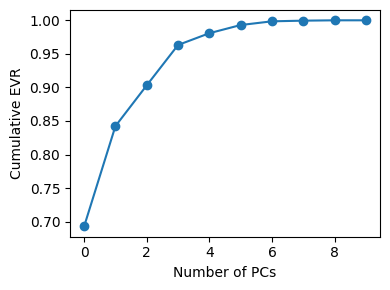

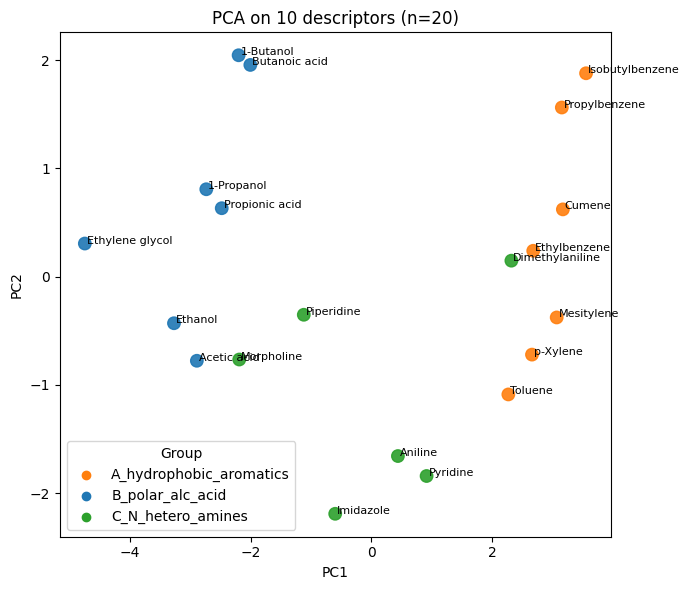

In [26]:
# Q2 - Solution

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

desc_cols = ["MolWt","LogP","TPSA","NumRings",
             "NumHAcceptors","NumHDonors","NumRotatableBonds",
             "HeavyAtomCount","FractionCSP3","NumAromaticRings"]

X_desc = df10_20[desc_cols].to_numpy()
X_desc_std = StandardScaler().fit_transform(X_desc)

pca_desc_full = PCA().fit(X_desc_std)
Z_desc = pca_desc_full.transform(X_desc_std)[:, :2]

# color map by group
group_to_color = {"A_hydrophobic_aromatics":"tab:orange",
                  "B_polar_alc_acid":"tab:blue",
                  "C_N_hetero_amines":"tab:green"}
colors = df10_20["Group"].map(group_to_color).to_numpy()

# explained variance
plt.figure(figsize=(4,3))
plt.plot(np.cumsum(pca_desc_full.explained_variance_ratio_), marker="o")
plt.xlabel("Number of PCs"); plt.ylabel("Cumulative EVR"); plt.tight_layout(); plt.show()

# 2D scatter with labels
plt.figure(figsize=(7,6))
plt.scatter(Z_desc[:,0], Z_desc[:,1], s=80, c=colors, alpha=0.9)
for i, name in enumerate(df10_20["Compound Name"]):
    plt.text(Z_desc[i,0]+0.03, Z_desc[i,1], name, fontsize=8)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA on 10 descriptors (n=20)")
# legend
for g, col in group_to_color.items():
    plt.scatter([], [], c=col, label=g)
plt.legend(title="Group", loc="best")
plt.tight_layout(); plt.show()


### Q3

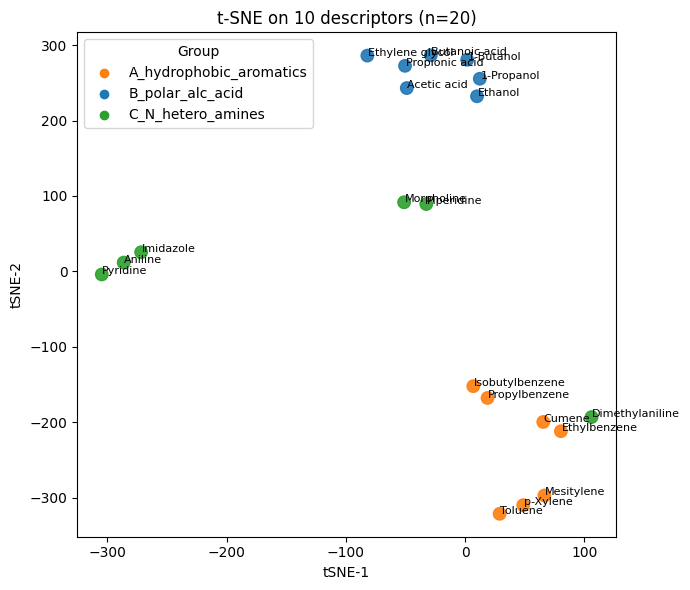

In [27]:
# Q3 - Solution

from sklearn.manifold import TSNE

tsne_desc = TSNE(n_components=2, perplexity=2, learning_rate="auto",
                 init="pca", random_state=0)
Y_desc = tsne_desc.fit_transform(X_desc_std)

plt.figure(figsize=(7,6))
plt.scatter(Y_desc[:,0], Y_desc[:,1], s=80, c=colors, alpha=0.9)
for i, name in enumerate(df10_20["Compound Name"]):
    plt.text(Y_desc[i,0]+0.5, Y_desc[i,1], name, fontsize=8)
plt.xlabel("tSNE-1"); plt.ylabel("tSNE-2"); plt.title("t-SNE on 10 descriptors (n=20)")
for g, col in group_to_color.items():
    plt.scatter([], [], c=col, label=g)
plt.legend(title="Group", loc="best")
plt.tight_layout(); plt.show()


### Q4

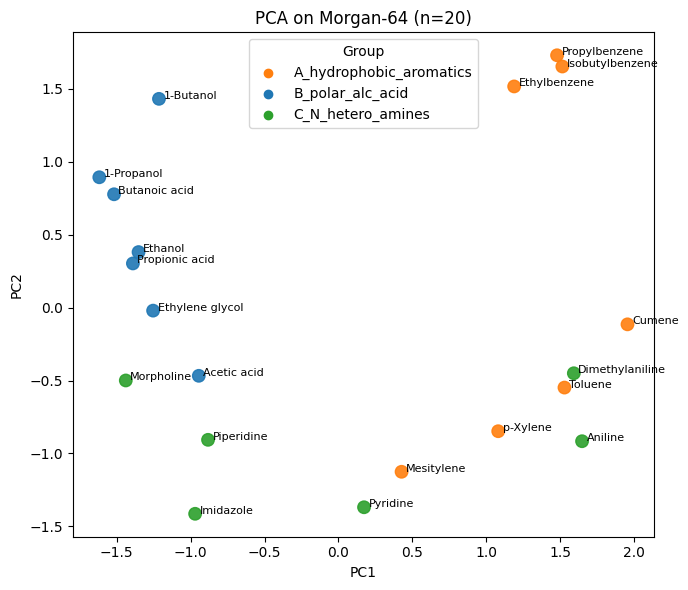

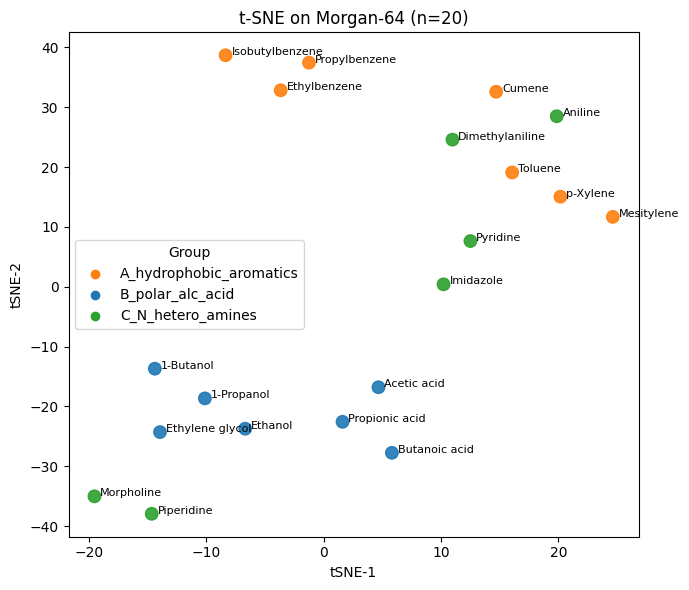

In [28]:
# Q4 - Solution

# 0/1 matrix from bitstrings
X_fp = np.array([[int(ch) for ch in s] for s in df_fp_20["Fingerprint"]], dtype=float)

# PCA on fingerprint bits
pca_fp = PCA(n_components=2, random_state=0).fit(X_fp)
Z_fp_pca = pca_fp.transform(X_fp)

plt.figure(figsize=(7,6))
plt.scatter(Z_fp_pca[:,0], Z_fp_pca[:,1], s=80, c=colors, alpha=0.9)
for i, name in enumerate(df_fp_20["Compound Name"]):
    plt.text(Z_fp_pca[i,0]+0.03, Z_fp_pca[i,1], name, fontsize=8)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA on Morgan-64 (n=20)")
for g, col in group_to_color.items():
    plt.scatter([], [], c=col, label=g)
plt.legend(title="Group", loc="best")
plt.tight_layout(); plt.show()

# t-SNE on fingerprint bits
tsne_fp = TSNE(n_components=2, perplexity=5, learning_rate="auto",
               init="pca", random_state=0)
Y_fp = tsne_fp.fit_transform(X_fp)

plt.figure(figsize=(7,6))
plt.scatter(Y_fp[:,0], Y_fp[:,1], s=80, c=colors, alpha=0.9)
for i, name in enumerate(df_fp_20["Compound Name"]):
    plt.text(Y_fp[i,0]+0.5, Y_fp[i,1], name, fontsize=8)
plt.xlabel("tSNE-1"); plt.ylabel("tSNE-2"); plt.title("t-SNE on Morgan-64 (n=20)")
for g, col in group_to_color.items():
    plt.scatter([], [], c=col, label=g)
plt.legend(title="Group", loc="best")
plt.tight_layout(); plt.show()


### Q5

In [29]:
# Q5 - Solution

from sklearn.metrics import pairwise_distances
from rdkit import DataStructs

# choose a query row
q = 3  # change during class to test different queries

# 1) Euclidean on standardized 10D descriptors
D_eu = pairwise_distances(X_desc_std, metric="euclidean")
order_eu = np.argsort(D_eu[q])
nn_eu_idx = [i for i in order_eu if i != q][:5]

print(f"Query: {df10_20.loc[q,'Compound Name']}  |  Group: {df10_20.loc[q,'Group']}")
print("\nNearest 5 by Euclidean (10 descriptors):")
for j in nn_eu_idx:
    print(f"  {df10_20.loc[j,'Compound Name']:24s}  group={df10_20.loc[j,'Group']:22s}  d_eu={D_eu[q,j]:.3f}")

# 2) Tanimoto on 64-bit fingerprints
def fp_string_to_bvect(fp_str):
    arr = [int(ch) for ch in fp_str]
    bv = DataStructs.ExplicitBitVect(len(arr))
    for k, b in enumerate(arr):
        if b: bv.SetBit(k)
    return bv

fps = [fp_string_to_bvect(s) for s in df_fp_20["Fingerprint"]]
S_tan = np.zeros((len(fps), len(fps)))
for i in range(len(fps)):
    S_tan[i, :] = DataStructs.BulkTanimotoSimilarity(fps[i], fps)
D_tan = 1.0 - S_tan

order_tan = np.argsort(D_tan[q])
nn_tan_idx = [i for i in order_tan if i != q][:5]

print("\nNearest 5 by Tanimoto (Morgan-64):")
for j in nn_tan_idx:
    print(f"  {df10_20.loc[j,'Compound Name']:24s}  group={df10_20.loc[j,'Group']:22s}  d_tan={D_tan[q,j]:.3f}")


Query: p-Xylene  |  Group: A_hydrophobic_aromatics

Nearest 5 by Euclidean (10 descriptors):
  Mesitylene                group=A_hydrophobic_aromatics  d_eu=0.840
  Toluene                   group=A_hydrophobic_aromatics  d_eu=0.859
  Ethylbenzene              group=A_hydrophobic_aromatics  d_eu=1.281
  Cumene                    group=A_hydrophobic_aromatics  d_eu=1.572
  Dimethylaniline           group=C_N_hetero_amines       d_eu=2.267

Nearest 5 by Tanimoto (Morgan-64):
  Toluene                   group=A_hydrophobic_aromatics  d_tan=0.300
  Mesitylene                group=A_hydrophobic_aromatics  d_tan=0.333
  Dimethylaniline           group=C_N_hetero_amines       d_tan=0.667
  Cumene                    group=A_hydrophobic_aromatics  d_tan=0.688
  Ethylbenzene              group=A_hydrophobic_aromatics  d_tan=0.688
